# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka

from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets

### Generate data

In [2]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

### Nonlinear SVM 

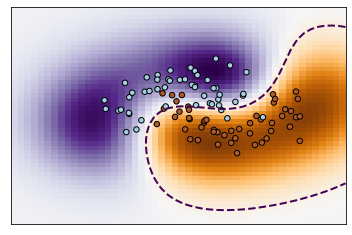

In [3]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

### RBF Fourier random features (sklearn)

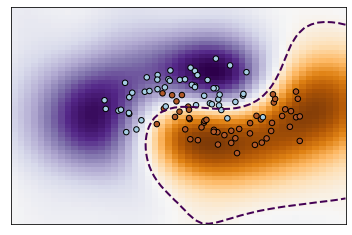

In [4]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

### RBF Fourier random features (our implementation)

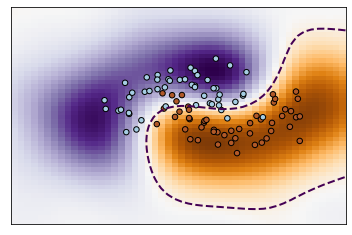

In [5]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma, n_random_features)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

### Matérn Fourier random features (our implementation)

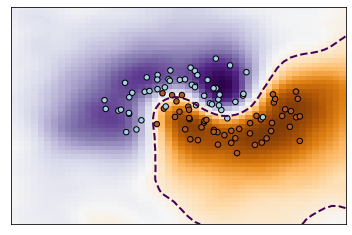

In [6]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu, n_random_features)    
random_features = matern_sampler.fit_transform(X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

### Nystroem features (our implementation)

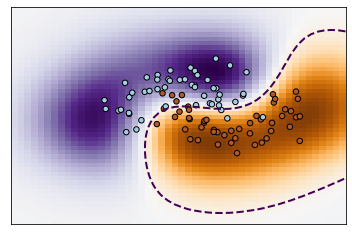

In [7]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel, n_nystroem_features)
nystroem_features = nystroem_sampler.fit_transform(X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py



In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import warnings


# Scaling data to the range [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)


# Define parameters search space
d = X.shape[1] # data dimension
gamma_parameters = np.logspace(-2, 3, 6, base=4)/d 
sigma_parameters = np.sqrt(1.0/2.0/gamma_parameters)
nu_parameters = np.linspace(1, 3, 5)
n_features_parameters = [20, 50, 100]

# Define parameters for each model
parameters = [
    {'svc_rbf_sk__gamma': gamma_parameters},
    {'rbf_sk__gamma': gamma_parameters, 'rbf_sk__n_components': n_features_parameters},
    {'rbf_ka__sigma': sigma_parameters, 'rbf_ka__n_random_features': n_features_parameters},
    {'matern_ka__scale': sigma_parameters, 'matern_ka__nu': nu_parameters, 'matern_ka__n_random_features': n_features_parameters},
    {'nystroem_rbf_ka__kernel__length_scale': sigma_parameters, 'nystroem_rbf_ka__n_random_features': n_features_parameters}
]

# Define models to evaluate as (name, Pipeline) tuple 
models = [
    ('Nonlinear SVM (SKlearn)', Pipeline([('svc_rbf_sk', svm.SVC(kernel='rbf'))])),
    ('RBF Fourier random features (Sklearn)', Pipeline([('rbf_sk', RBFSampler()),
                                                        ('svc_linear_sk', svm.SVC(kernel='linear'))])),
    ('RBF Fourier random features (our implementation)', Pipeline([('rbf_ka', ka.RandomFeaturesSamplerRBF()),
                                                                   ('svc_linear_sk', svm.SVC(kernel='linear'))])),
    ('Matérn Fourier random features (our implementation)', Pipeline([('matern_ka', ka.RandomFeaturesSamplerMatern()), 
                                                                      ('svc_linear_sk', svm.SVC(kernel='linear'))])),
    ('Nystroem features (our implementation)', Pipeline([('nystroem_rbf_ka', ka.NystroemFeaturesSampler()),
                                                        ('svc_linear_sk', svm.SVC(kernel='linear'))]))
]

# Execute and resume results
for (name, pipeline), param_grid in zip(models, parameters):
    print(name)
    clf = GridSearchCV(
        pipeline,
        param_grid, 
        cv=StratifiedKFold(5, shuffle=True)
    )
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        clf.fit(X_scaled, y)
    print(' - Best parameters set found on development set:\n\t*', clf.best_params_)
    
    test_score = clf.score(X_test_scaled, y_test)
    print(f" - Test score: {test_score:.3f}\n")
    

Nonlinear SVM (SKlearn)
 - Best parameters set found on development set:
	* {'svc_rbf_sk__gamma': 8.0}
 - Test score: 0.901

RBF Fourier random features (Sklearn)
 - Best parameters set found on development set:
	* {'rbf_sk__gamma': 8.0, 'rbf_sk__n_components': 50}
 - Test score: 0.900

RBF Fourier random features (our implementation)
 - Best parameters set found on development set:
	* {'rbf_ka__n_random_features': 100, 'rbf_ka__sigma': 0.25}
 - Test score: 0.899

Matérn Fourier random features (our implementation)
 - Best parameters set found on development set:
	* {'matern_ka__n_random_features': 50, 'matern_ka__nu': 2.0, 'matern_ka__scale': 0.25}
 - Test score: 0.898

Nystroem features (our implementation)
 - Best parameters set found on development set:
	* {'nystroem_rbf_ka__kernel__length_scale': 0.25, 'nystroem_rbf_ka__n_random_features': 100}
 - Test score: 0.901



A la vista de los resultados obtenidos, vemos que nuestra implementación de Nystroem compite con el clasificar no lineal con núcleo RBF implementado por SKlearn así como con la aproximación por RBF de Sklearn. El núcleo aproximado por nuestra implementación de Nystroem utiliza el parámetro length_scale igual a $0.25$, que se corresponde con el mismo valor $\gamma=8.0$ obtenido por SKlearn. Además, ambas aproximaciones utilizan el mismo número de características, en concreto, 50.

Para nuestra aproximación de RBF, se necesita un número mayor de características, en total, 100, que son las características con las que se ha entrenado la matriz y se utiliza el mismo valor para el parámetro $sigma$ del núcleo del RBF. 

Respecto a la mejor aproximación utilizando Matérn, se necesitan 50 características, un parámetro $\nu=2.0$ y una escala de $0.25$, que coincide de nuevo con el parámetro $\gamma=8.0$.

Concluimos que todas nuestras implementaciones son competitivas respecto a las de SKlearn, obteniéndose para todas ellas un score $\sim 0.9$ y aproximando de manera eficiente la matriz de Kernel tanto para los datos de entrenamiento como para los datos de test.